# Differentiating Depression

## Table of Contents
1. [Problem Statement](#problemstatement)
2. [Background](#background)
3. [Assumptions](#assumptions)
4. [r/Depression Data Cleaning](#depressiondatacleaning)
5. [r/SuicideWatch Data Cleaning](#suicidewatchcleaning)
6. [EDA](#eda)
    1. [Heatmap](#heatmap)
    2. [Count Vectorizer](#countvectorizer)
    3. [TF-IDF Vectorizer](#tfidf)
    4. [Baseline Models](#baselinemodels)
        1. [Multinomial NB with Count Vectorizer](#multinbcvecbvaseline)
        2. [Multinomial NB with TF-IDF Vectorizer](#multinbtvecbaseline)
        3. [Random Forests with Count Vectorizer](#rftvecbaseline)
7. [Modelling](#modelling)
    1. [Multinomial NB](#multinbmodel)
    2. [Random Forest](#rfmodel)
8. [Insights](#insights)
9. [Conclusion and Recommendations](#conclusion)

## Problem Statement<a name=problemstatement></a>

The pandemic has resulted in a surge in people with mental health problems. As they are less likely to see a therapist in person, increasing numbers of people are turning to online avenues for consolation. 

Listening Hearts, a not-for-profit charity that is trying to provide free mental healthcare, is looking to identify those more urgent need of mental healthcare in order to prioritise their clients better. To accomplish this, they have asked you to create a model that is able to identify callers/messages that have more suicidal undertones than regular depression.


## Background<a name=background></a>

The [r/Depression subreddit](https://www.reddit.com/r/depression/) describes itself as a community that provides "peer support for anyone struggling with a depressive disorder" while the [r/SuicideWatch subreddit](https://www.reddit.com/r/SuicideWatch/) describes itself as a community that provides "peer support for anyone struggling with suicidal thoughts". These are safe spaces online where strangers can gather and voice out their concerns and be consoled.
</p>
However, these subreddits are supposed to be havens similarly struggling individuals, there is no guarantee that anybody posting on these subreddits are indeed suffering from mental distress. As we have decided to use these subreddits to scrape our data to train our classifier model, our use of this data must come with some assumptions.

## Assumptions<a name=assumptions></a>

1) **The subreddits have been well-moderated to the extent that there are no spam or off-topic posts**:</p>

- Considering the sensitive and serious nature of the topic of this subreddit, it will not be unusual to assume that these subreddits are more heavily moderated and well-maintained that most other subreddits
- If there are spam or off-topic posts that we did not catch, the effectiveness of our classifier will be reduced


2) **Posters are accurately conveying their emotions in their posts and are submitting their posts to the appropriate subreddits**:</p>

- The assumption is that the posts that are submitted are communicating exactly how the author is feeling, if they are truly suicidal, depressed, or otherwise
- As this is the only data we are using, we have to assume that these posts with depressive/suicidal undertones are written by people who are depressed/suicidal respectively i.e. depressed posters are not posting posts with suicidal ideation and vice versa
- Additonally, this also means that there are no posters in these subreddits that shouldn't genuinely be there i.e. no mentally healthy posters posting
- This requires a high level of self-awareness and acceptance from our posters

3) **Posters are aware of the existence of both subreddits**:</p>

- The assumption is that the posters are aware that both subreddits exist and each has its own purpose, so that they will post in the subreddit more relevant to their issues when the need arises


## Imports<a name=imports></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


In [2]:
pd.options.display.max_colwidth = None
pd.options.display.max_columns = 100

## r/Depression Data Cleaning<a name=depressiondatacleaning></a>
---

### Basic Cleaning

Dropping null values (none in `depression`) , dropping duplicate posts (45 in `depression`), creating a feature `alltext` that combines `title` and `selftext`.

In [3]:
depression = pd.read_csv('../datasets/depression.csv')

In [4]:
depression.dropna(inplace=True)

In [5]:
depression.drop_duplicates(subset='selftext').count()

title       9973
selftext    9973
dtype: int64

In [6]:
depression = depression.drop_duplicates(subset='selftext')

In [7]:
def all_text(row):
    return row['title'] + " " + row['selftext']

In [8]:
depression['alltext'] = depression.apply(all_text, axis=1)

### Stopwords

We used `stopword.words('english')` as the basic list of stopwords, but also further added to that list based on words that we noticed would not be a good predictor i.e. either too irreleveant or too specific to either subreddit 

In [9]:
#### ADDITIONAL STOP WORDS ####

# stopwords_add will be our list of stopwords that we will add on to when we wish to remove additional words 
# i.e. words that are too specific to either subreddit or hold too low predicitive power

stopwords_add = stopwords.words('english')

### Tokenizing

We used the default `token_pattern` regular expression of `r"(?u)\b\w\w+\b"` from the built-in tokenizer in `CountVectorizer`. This regular expression captures any group of characters (alphabetical, numerical, and symbols) of character length two or greater as a token. 

In [10]:
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")

### Word Counts

We created new features of `title_word_count` and `selftext_word_count` to see if they are able to help our classification later.
</p>
</p>


In [11]:
def word_counter(row):
    return len(tokenizer.tokenize(row))

In [12]:
depression['title_word_count'] = depression['title'].map(word_counter)
depression['selftext_word_count'] = depression['selftext'].map(word_counter)


### Sentence Counts

We created new features of `title_sentence_count` and `selftext_sentence_count` to see if they are able to help our classification later.
</p>
</p>


In [13]:
def sentence_counter(row):
    return len(sent_tokenize(row))

In [14]:
%%time
depression['title_sentence_count'] = depression['title'].map(sentence_counter)
depression['selftext_sentence_count'] = depression['selftext'].map(sentence_counter)


CPU times: total: 2.03 s
Wall time: 2.03 s


### Average Words per Sentence

We created new features of `avg_word_sent_title` and `avg_word_sent_selftext` to see if they are able to help our classification later.
</p>
</p>


In [15]:
depression['avg_word_sent_title'] = depression['title_word_count'] / depression['title_sentence_count']
depression['avg_word_sent_selftext'] = depression['selftext_word_count'] / depression['selftext_sentence_count']


In [16]:
depression.describe()

,title_word_count,selftext_word_count,title_sentence_count,selftext_sentence_count,avg_word_sent_title,avg_word_sent_selftext
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,5.636920,120.115011,1.045824,8.216184,5.445486,18.862754
std,3.321644,91.018718,0.228807,6.841363,3.202607,20.980973
min,1.000000,6.000000,1.000000,1.000000,0.500000,1.714286
25%,3.000000,48.000000,1.000000,3.000000,3.000000,10.400000
50%,5.000000,97.000000,1.000000,6.000000,5.000000,14.000000
75%,8.000000,171.000000,1.000000,11.000000,7.000000,19.400000
max,15.000000,400.000000,5.000000,66.000000,15.000000,350.000000


### Classifying Label

Assigning a classifying label to our posts from r/Depression. We will label it as 0 as the posts from r/SuicideWatch are the more important class

In [17]:
# label of 0 as it is less important class
depression['label'] = 0

### Repeated Words

It is not uncommon for posts to overly repeat a particular phrase or word. While the content of the post is still legitimate and sincere, the overusage of words and phrases will negatively affect our models as these particularly posts will give unwarranted weight to a few select words.
</p>
</p>

In this case, we defined a post to be overly using a word or phrase if the word or phrase appears at least 5 times and accounts for at least 10% of the `post_tokens` (34 in `depression`).

In [18]:
def word_repeater(row, col):
    post_tokens = tokenizer.tokenize(row[col])
    for word in post_tokens:
        if word not in stopwords.words('english') and \
        post_tokens.count(word) > (0.1 * len(post_tokens)) and \
        post_tokens.count(word) > 5:
            return 1
        else:
            continue

In [19]:
%%time
#####RUN TIME ~ 6 MINUTES#####
depression['repeated_words'] = depression.apply(word_repeater, col='alltext', axis=1)

CPU times: total: 5min 42s
Wall time: 5min 44s


In [20]:
depression[depression['repeated_words'] == 1].count()

title                      34
selftext                   34
alltext                    34
title_word_count           34
selftext_word_count        34
title_sentence_count       34
selftext_sentence_count    34
avg_word_sent_title        34
avg_word_sent_selftext     34
label                      34
repeated_words             34
dtype: int64

In [21]:
depression = depression.drop(depression[depression['repeated_words'] == 1].index)

Dropping the `repeated_words` column as we have no more use for it.

In [22]:
depression.drop(columns='repeated_words', inplace=True)

### Minimum and Maximum Post Lengths

The parameters that we set in our [data scraping function](http://localhost:8888/notebooks/project_3/Project%203%20Data%20Scraping.ipynb) were instrumental in excluding posts with `title_word_count` < 1, `title_word_count` > 15, `selftext_word_count` < 6 , and `selftext_word_count` > 400. 

In [23]:
depression.describe()

,title_word_count,selftext_word_count,title_sentence_count,selftext_sentence_count,avg_word_sent_title,avg_word_sent_selftext,label
count,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.0
mean,5.642821,120.265520,1.045980,8.218030,5.450733,18.842242,0.0
std,3.323202,91.050633,0.229182,6.819633,3.204142,20.949331,0.0
min,1.000000,6.000000,1.000000,1.000000,0.500000,1.714286,0.0
25%,3.000000,48.000000,1.000000,3.000000,3.000000,10.428571,0.0
50%,5.000000,97.000000,1.000000,6.000000,5.000000,14.000000,0.0
75%,8.000000,171.000000,1.000000,11.000000,7.000000,19.400000,0.0
max,15.000000,400.000000,5.000000,50.000000,15.000000,350.000000,0.0


## r/SuicideWatch Data Cleaning<a name=suicidewatchcleaning></a>
---

### Basic Cleaning

Dropping null values ( in `suicidewatch`) , dropping duplicate posts (35 in `suicidewatch`) creating a feature `alltext` that combines `title` and `selftext.`

In [24]:
suicidewatch = pd.read_csv('../datasets/suicidewatch.csv')

In [25]:
suicidewatch.dropna(inplace=True)

In [26]:
suicidewatch = suicidewatch.drop_duplicates(subset='selftext')

In [27]:
def all_text(row):
    return row['title'] + " " + row['selftext']

In [28]:
suicidewatch['alltext'] = suicidewatch.apply(all_text, axis=1)

### Word Counts

We created new features of `title_word_count`, `selftext_word_count`, and `alltext_word_count` to see if they are able to help our classification later.
</p>
</p>


In [29]:
def word_counter(row):
    return len(tokenizer.tokenize(row))

In [30]:
suicidewatch['title_word_count'] = suicidewatch['title'].map(word_counter)
suicidewatch['selftext_word_count'] = suicidewatch['selftext'].map(word_counter)


### Sentence Counts

We created new features of `title_sentence_count` and `selftext_sentence_count` to see if they are able to help our classification later.
</p>
</p>


In [31]:
def sentence_counter(row):
    return len(sent_tokenize(row))

In [32]:
%%time
suicidewatch['title_sentence_count'] = suicidewatch['title'].map(sentence_counter)
suicidewatch['selftext_sentence_count'] = suicidewatch['selftext'].map(sentence_counter)


CPU times: total: 1.91 s
Wall time: 1.91 s


### Average Words per Sentence

We created new features of `avg_word_sent_title` and `avg_word_sent_selftext` to see if they are able to help our classification later.
</p>
</p>


In [33]:
suicidewatch['avg_word_sent_title'] = suicidewatch['title_word_count'] / suicidewatch['title_sentence_count']
suicidewatch['avg_word_sent_selftext'] = suicidewatch['selftext_word_count'] / suicidewatch['selftext_sentence_count']


### Classifying Label

Assigning a classifying label to our posts from r/SuicideWatch. We will label it as 1 as its posts are of the more important class.

In [34]:
# label of 1 as it is the more important class
suicidewatch['label'] = 1

### Repeated Words

It is not uncommon for posts to overly repeat a particular phrase or word. While the content of the post is still legitimate and sincere, the overusage of words and phrases will negatively affect our models as these particularly posts will give unwarranted weight to a few select words.
</p>
</p>

In this case, we defined a post to be overly using a word or phrase if the word or phrase appears at least 5 times and accounts for at least 10% of the `post_tokens` (38 in `suicidewatch`).

In [35]:
%%time
##### RUN TIME ~ 4 MINUTES #####
suicidewatch['repeated_words'] = suicidewatch.apply(word_repeater, col='alltext', axis=1)

CPU times: total: 5min 9s
Wall time: 5min 13s


In [36]:
suicidewatch[suicidewatch['repeated_words'] == 1]

,title,selftext,alltext,title_word_count,selftext_word_count,title_sentence_count,selftext_sentence_count,avg_word_sent_title,avg_word_sent_selftext,label,repeated_words
277,sometimes,i just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dying,sometimes i just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just really feel like dyingi just

In [37]:
suicidewatch = suicidewatch.drop(suicidewatch[suicidewatch['repeated_words'] == 1].index)

Dropping the `repeated_words` column as we have no more use for it.

In [38]:
suicidewatch.drop(columns='repeated_words', inplace=True)

### Minimum and Maximum Post Lengths

The parameters that we set in our [data scraping function](http://localhost:8888/notebooks/project_3/Project%203%20Data%20Scraping.ipynb) were instrumental in excluding posts with `title_word_count` < 1, `title_word_count` > 15, `selftext_word_count` < 6 , and `selftext_word_count` > 400. 

In [39]:
suicidewatch.describe()

,title_word_count,selftext_word_count,title_sentence_count,selftext_sentence_count,avg_word_sent_title,avg_word_sent_selftext,label
count,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.0
mean,5.583509,106.851181,1.048969,7.822926,5.381423,18.259091,1.0
std,3.332971,86.966738,0.244232,6.902312,3.201916,22.541386,0.0
min,1.000000,6.000000,1.000000,1.000000,0.500000,1.222222,1.0
25%,3.000000,39.000000,1.000000,3.000000,3.000000,9.500000,1.0
50%,5.000000,82.000000,1.000000,6.000000,5.000000,13.000000,1.0
75%,7.000000,151.000000,1.000000,11.000000,7.000000,18.500000,1.0
max,15.000000,400.000000,5.000000,52.000000,15.000000,399.000000,1.0


## Combining our Data<a name=datacombine></a>
---

Ensuring that each dataframe has the same length:

In [40]:
print(f"The depression dataframe has {depression.shape[0]} rows")
print(f"The suicidewatch dataframe has {suicidewatch.shape[0]} rows")

The depression dataframe has 9939 rows
The suicidewatch dataframe has 9945 rows


In [41]:
suicidewatch  = suicidewatch [:depression.shape[0]]

In [42]:
df = pd.concat([depression,suicidewatch], axis =0, ignore_index=True)

In [43]:
df.to_csv('../datasets/combined_cleaned_df.csv', index_label=False)

## EDA <a name=eda></a>

### Word Count

### `title_word_count`

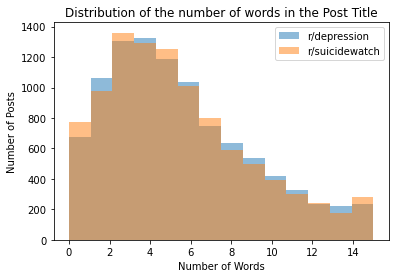

In [44]:
bins = np.linspace(0, 15, 15)

plt.hist(depression['title_word_count'], bins, alpha=0.5, label="r/depression")
plt.hist(suicidewatch['title_word_count'], bins, alpha=0.5, label="r/suicidewatch")

plt.title('Distribution of the number of words in the Post Title')
plt.xlabel("Number of Words")
plt.ylabel("Number of Posts")

plt.legend(loc='upper right')

plt.savefig('../assets/title_word.jpg', dpi=160)

In [45]:
depression['title_word_count'].describe()

count    9939.000000
mean        5.642821
std         3.323202
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        15.000000
Name: title_word_count, dtype: float64

In [46]:
suicidewatch['title_word_count'].describe()

count    9939.000000
mean        5.582755
std         3.330985
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        15.000000
Name: title_word_count, dtype: float64

Posts from both r/Depression and r/SuicideWatch seemed to have close to identical word counts in their titles.

### `selftext_word_count`

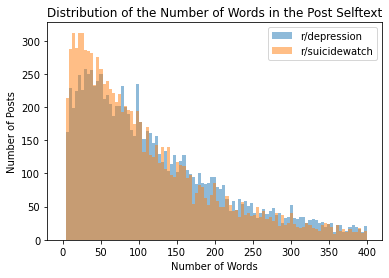

In [47]:
bins = np.linspace(0, 400, 100)

plt.hist(depression['selftext_word_count'], bins, alpha=0.5, label="r/depression")
plt.hist(suicidewatch['selftext_word_count'], bins, alpha=0.5, label="r/suicidewatch")

plt.title('Distribution of the Number of Words in the Post Selftext')
plt.xlabel("Number of Words")
plt.ylabel("Number of Posts")

plt.legend(loc='upper right')

plt.savefig('../assets/selftext_word.jpg', dpi=160)

In [48]:
depression['selftext_word_count'].describe()

count    9939.000000
mean      120.265520
std        91.050633
min         6.000000
25%        48.000000
50%        97.000000
75%       171.000000
max       400.000000
Name: selftext_word_count, dtype: float64

In [49]:
suicidewatch['selftext_word_count'].describe()

count    9939.000000
mean      106.873428
std        86.981105
min         6.000000
25%        39.000000
50%        82.000000
75%       151.000000
max       400.000000
Name: selftext_word_count, dtype: float64

Posts from both r/Depression seem to have a higher number of words on average than posts from r/SuicideWatch. It also appears that the posters in r/SuicideWatch seem to prefer composing shorter posts with a large majority of posts there being between 0-40 words long, compared to r/Depression where not only are the majority of posts there around 40-50 words long, but they are also comparatively a lot more spread out.

### Sentence Count

### `title_sentence_count`

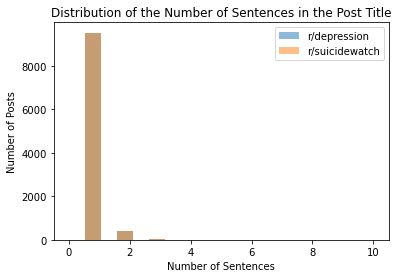

In [50]:
bins = np.linspace(0, 10, 20)

plt.hist(depression['title_sentence_count'], bins, alpha=0.5, label="r/depression")
plt.hist(suicidewatch['title_sentence_count'], bins, alpha=0.5, label="r/suicidewatch")

plt.title('Distribution of the Number of Sentences in the Post Title')
plt.xlabel("Number of Sentences")
plt.ylabel("Number of Posts")

plt.legend(loc='upper right')

plt.savefig('../assets/title_sent.jpg', dpi=160)

Posts from both r/Depression and r/SuicideWatch had identical number of sentences in their titles. This is not really surprising, as posts are rarely more than 1 sentence anyway. This is likely to hold true for posts in other subreddits as well.

In [51]:
depression['title_sentence_count'].describe()

count    9939.000000
mean        1.045980
std         0.229182
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: title_sentence_count, dtype: float64

In [52]:
suicidewatch['title_sentence_count'].describe()

count    9939.000000
mean        1.048999
std         0.244303
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: title_sentence_count, dtype: float64

### `selftext_sentence_count`

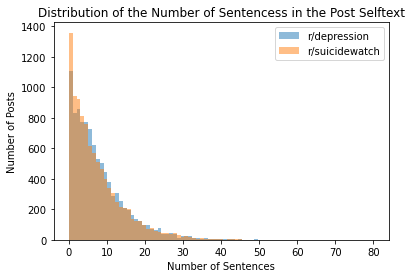

In [53]:
bins = np.linspace(0, 80, 80)

plt.hist(depression['selftext_sentence_count'], bins, alpha=0.5, label="r/depression")
plt.hist(suicidewatch['selftext_sentence_count'], bins, alpha=0.5, label="r/suicidewatch")

plt.title('Distribution of the Number of Sentencess in the Post Selftext')
plt.xlabel("Number of Sentences")
plt.ylabel("Number of Posts")

plt.legend(loc='upper right')

plt.savefig('../assets/selftext_sent.jpg', dpi=160)

In [54]:
depression['selftext_sentence_count'].describe()

count    9939.000000
mean        8.218030
std         6.819633
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max        50.000000
Name: selftext_sentence_count, dtype: float64

In [55]:
suicidewatch['selftext_sentence_count'].describe()

count    9939.000000
mean        7.822517
std         6.903709
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max        52.000000
Name: selftext_sentence_count, dtype: float64

depression has a higher average number words in the selftext of their posts and most 

### Average Number of Words in a Sentence

### `avg_word_sent_title`

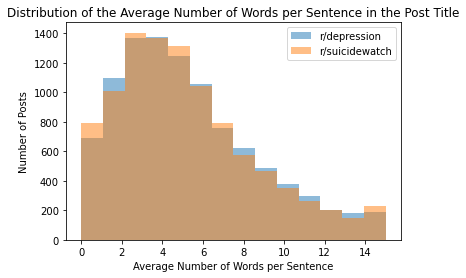

In [56]:
bins = np.linspace(0, 15, 15)

plt.hist(depression['avg_word_sent_title'], bins, alpha=0.5, label="r/depression")
plt.hist(suicidewatch['avg_word_sent_title'], bins, alpha=0.5, label="r/suicidewatch")

plt.title('Distribution of the Average Number of Words per Sentence in the Post Title')
plt.xlabel("Average Number of Words per Sentence")
plt.ylabel("Number of Posts")

plt.legend(loc='upper right')

plt.savefig('../assets/title_wps.jpg', dpi=160)

In [57]:
depression['avg_word_sent_title'].describe()

count    9939.000000
mean        5.450733
std         3.204142
min         0.500000
25%         3.000000
50%         5.000000
75%         7.000000
max        15.000000
Name: avg_word_sent_title, dtype: float64

In [58]:
suicidewatch['avg_word_sent_title'].describe()

count    9939.000000
mean        5.380546
std         3.199716
min         0.500000
25%         3.000000
50%         5.000000
75%         7.000000
max        15.000000
Name: avg_word_sent_title, dtype: float64

### `avg_word_sent_selftext`

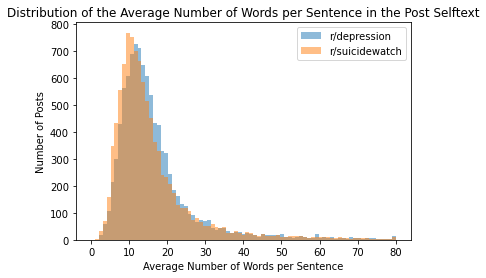

In [59]:
bins = np.linspace(0, 80, 80)

plt.hist(depression['avg_word_sent_selftext'], bins, alpha=0.5, label="r/depression")
plt.hist(suicidewatch['avg_word_sent_selftext'], bins, alpha=0.5, label="r/suicidewatch")

plt.title('Distribution of the Average Number of Words per Sentence in the Post Selftext')
plt.xlabel("Average Number of Words per Sentence")
plt.ylabel("Number of Posts")

plt.legend(loc='upper right')

plt.savefig('../assets/selftext_wps.jpg', dpi=160)

In [60]:
depression['avg_word_sent_selftext'].value_counts()

11.000000    134
9.000000     133
12.000000    130
13.000000    124
14.000000    119
            ... 
5.367347       1
16.916667      1
8.071429       1
12.318182      1
8.647059       1
Name: avg_word_sent_selftext, Length: 2302, dtype: int64

In [61]:
suicidewatch['avg_word_sent_selftext'].describe()

count    9939.000000
mean       18.264984
std        22.546757
min         1.222222
25%         9.500000
50%        13.000000
75%        18.500000
max       399.000000
Name: avg_word_sent_selftext, dtype: float64

depression has a higher average number words in the selftext of their posts and most 

### Heatmap<a name=heatmap></a>

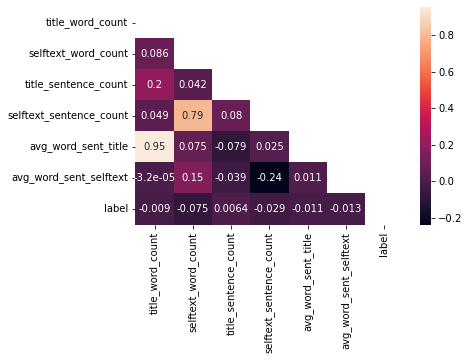

In [62]:
heatmap = sns.heatmap(df.corr(), annot=True, mask=np.triu(df.corr())).get_figure()

heatmap.savefig('../assets/heatmap.jpg', dpi=160)

From our heatmap, we can see that none of the number of words, number of sentences, and average number of words per sentence all do not have any meaningful correlalation with our target, label.
</p>
It was initially thought that there could be some slight difference between posts from the the two subreddits, such as posts from r/SuicideWatch being shorter

As there is no use for the word count, sentence count, and average words per sentence features, we will drop them.

In [63]:
df = df[['title', 'selftext', 'alltext', 'label']]

### Count Vectorizer

for both our vectorizers, we added stopwords relating to the subreddit names so that they won't be included in the counting and potentially skew our results.

In [64]:
stopwords_subr = ['depression', 'suicidewatch', 'suicide', 'watch']

In [65]:
stopwords_add += stopwords_subr

In [66]:
# Split the data into the training and testing sets.
X = df['alltext']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [67]:
# Instantiate a CountVectorizer for baseline model/accuracy
cvec = CountVectorizer(stop_words=stopwords_add)


In [68]:
# Fit and transform the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [69]:
X_train = cvec.transform(X_train)

In [70]:
X_train.shape

(15902, 24604)

In [71]:
# Transform test
X_test = cvec.transform(X_test)

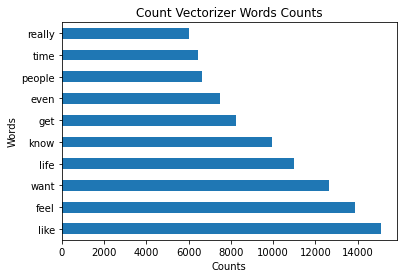

In [72]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names_out())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

plt.title("Count Vectorizer Words Counts")
plt.xlabel("Counts")
plt.ylabel("Words")

plt.savefig('../assets/cvec_popular_words.jpg', dpi=160)

Some words such as 'like' and 'feel' are occuring too often. Can reduce with `max_df` parameter of `CountVectorizer`

### TF-IDF Vectorizer

In [73]:
# Split the data into the training and testing sets.
X = df['alltext']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [74]:
# Instantiate a CountVectorizer for baseline model/accuracy
tvec = TfidfVectorizer(stop_words=stopwords_add)


In [75]:
# Fit and transform the vectorizer on our corpus.
tvec.fit(X_train)

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [76]:
X_train = tvec.transform(X_train)

In [77]:
X_train.shape

(15902, 24604)

In [78]:
# Transform test
X_test = tvec.transform(X_test)

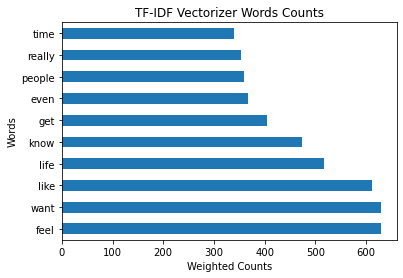

In [79]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=tvec.get_feature_names_out())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

plt.title("TF-IDF Vectorizer Words Counts")
plt.xlabel("Weighted Counts")
plt.ylabel("Words")

plt.savefig('../assets/tvec_popular_words.jpg', dpi=160)

Knowing which words are the least

## Baseline Models<a name=baselinemodels></a>

### Multinomial NB (Baseline Score) with Count Vectorizer<a name=multinbcvecbvaseline></a>


For our baseline score, the only adjustment we made to the base classifier model is the inclusion of stopwords that contained words from the names of the subreddits so as to prevent modelling on leaky data, which would likely give us an unreliable model due to posters possibly referencing the subreddit title.

Just to confirm this, we will compare the cross-validated scores of two Multinomial Naive Bayes models, first without using any stopwords at all, and then using our subreddit stopwords of `stopwords_subr`

In [80]:
# just as a reminder of what our subreddit stopwords are
stopwords_subr

['depression', 'suicidewatch', 'suicide', 'watch']

#### Cross-validated Score without Subreddit Stop Words

In [81]:
# Split the data into the training and testing sets.
X = df['alltext']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [82]:
# Instantiate a CountVectorizer for baseline model/accuracy
cvec = CountVectorizer()


In [83]:
# Fit and transform the vectorizer on our corpus.
cvec.fit(X_train, y_train)

CountVectorizer()

In [84]:
X_train = cvec.transform(X_train)

In [85]:
nb = MultinomialNB()

In [86]:
nb.fit(X_train, y_train)

MultinomialNB()

In [87]:
nb.score(X_train, y_train)

0.8055590491762042

In [88]:
X_test = cvec.transform(X_test)

In [89]:
nb.score(X_test, y_test)

0.7175553319919518

In [90]:
%%time
nb_train_cv_nosr = cross_val_score(
                nb,
                X_train,
                y_train,
                cv=200
    
            ).mean()

CPU times: total: 2.72 s
Wall time: 2.75 s


In [91]:
%%time
nb_test_cv_nosr = cross_val_score(
                nb,
                X_test,
                y_test,
                cv=200
            ).mean()

CPU times: total: 1.09 s
Wall time: 1.09 s


#### Cross-validated Score with Subreddit Stop Words

In [92]:
stopwords_subr = ['depression', 'suicidewatch', 'suicide', 'watch']

In [93]:
# Split the data into the training and testing sets.
X = df['alltext']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [94]:
# Instantiate a CountVectorizer for baseline model/accuracy
cvec = CountVectorizer(stop_words=stopwords_subr)


In [95]:
# Fit and transform the vectorizer on our corpus.
cvec.fit(X_train, y_train)

CountVectorizer(stop_words=['depression', 'suicidewatch', 'suicide', 'watch'])

In [96]:
X_train = cvec.transform(X_train)

In [97]:
nb = MultinomialNB()

In [98]:
nb.fit(X_train, y_train)

MultinomialNB()

In [99]:
nb.score(X_train, y_train)

0.8024776757640548

In [100]:
X_test = cvec.transform(X_test)

In [101]:
nb.score(X_test, y_test)

0.7069919517102615

In [102]:
%%time
nb_train_cv_sr = cross_val_score(
                nb,
                X_train,
                y_train,
                cv=200
            ).mean()

CPU times: total: 2.75 s
Wall time: 2.75 s


In [103]:
%%time
nb_test_cv_sr = cross_val_score(
                nb,
                X_test,
                y_test,
                cv=200
            ).mean()

CPU times: total: 1.08 s
Wall time: 1.09 s


In [104]:
print(f"Our baseline Multinomial NB model without subreddit stopwords has a cross-validated accuracy score of {round(nb_train_cv_nosr * 100, 1)}% on the \ntraining data compared to {round(nb_train_cv_sr * 100, 1)}% with the stopwords.")
print("")
print(f"Our baseline Multinomial NB model without subreddit stopwords has a cross-validated accuracy score of {round(nb_test_cv_nosr * 100, 1)}% on the \ntesting data compared to {round(nb_test_cv_sr * 100, 1)}% with the stopwords.")

Our baseline Multinomial NB model without subreddit stopwords has a cross-validated accuracy score of 71.8% on the 
training data compared to 71.2% with the stopwords.

Our baseline Multinomial NB model without subreddit stopwords has a cross-validated accuracy score of 71.3% on the 
testing data compared to 70.3% with the stopwords.


As we suspected, our model is more accurate without subreddit stopwords than with. The improvement is only slight, but to prevent data leaking, we elected to include subreddit stopwords for our baseline models

In [105]:
# creating a dataframe words_coefs that displays the predictive strength of each word for our multinomial NB model
words_coefs = pd.DataFrame(zip(cvec.get_feature_names_out(),
                (nb.feature_log_prob_[1] - nb.feature_log_prob_[0]).tolist()), columns=['word', 'coefficient'])

# ordering words_coefs by predictive strength with words that are strong predictors for r/SuicideWatch at the top 
# and words that are strong predictors for r/Depression at the bottom
words_coefs.sort_values(by='coefficient', ascending=False, inplace=True)

In [106]:
# creating a dataframe top_bot_10 of the 10 strongest predictors for both classes
top_bot_10 = pd.concat([words_coefs.head(10), words_coefs.tail(10)], axis=0)

In [107]:
# creating a columnn for absolute predictive strength
top_bot_10['coefficient_mod'] = abs(top_bot_10['coefficient'])

In [108]:
# ordering top_bot_10 by absolute predictive strength, regardless of which class they predict for
top_bot_10.sort_values(by='coefficient_mod', ascending=False, inplace=True)

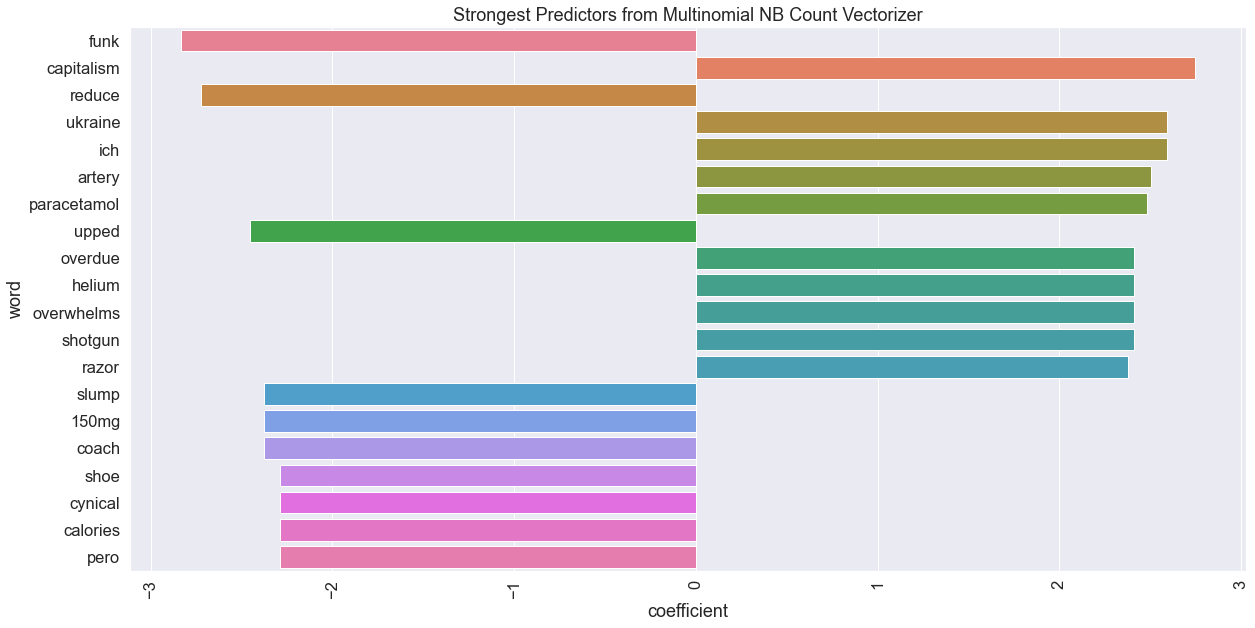

In [109]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=top_bot_10['word'], x=top_bot_10['coefficient'], palette ="husl")
sns.barplot(y=top_bot_10['word'], x=top_bot_10['coefficient'], palette ="husl").set(title="Strongest Predictors from Multinomial NB Count Vectorizer")
plt.xticks(rotation=90)
plt.show()

g.get_figure().savefig('../assets/multinb_cvec_strongest_words.jpg', dpi=160)

In [110]:
# creating a function to find the posts with particular words in them in order to discover the context
def word_finder(row, word):
    if word in row['alltext'].split(" "):
        return 1
    else:
        return 0

def post_with_word(dataframe, word):
    dataframe_1 = dataframe[['title', 'selftext', 'alltext','label']]
    dataframe_1[word] = dataframe_1.apply(word_finder, word=word, axis=1)
    print(dataframe_1[dataframe_1[word] == 1].count())
    return dataframe_1[dataframe_1[word] == 1]

#### Analysis

| word | context                                                                             | count | subreddit | 
|:-----|:------------------------------------------------------------------------------------|-------|------|
|funk|Generally used to describe depression e.g. 'no longer suicidal but can't get out of a funk'| 8 |Depression|
|capitalism|Capitalism appears to be a large concern for those feeling suicidal| 9 |SuicideWatch|
|reduce| Reducing pain, medication dosage, stress, depression | 17 (1) | Depression 
|ukraine| Russia/Ukraine war (largely by non-Ukrainians)| 7 (1) | SuicideWatch |
|ich| German word for I. Used often by German posters| 2 | SuicideWatch | 
|artery| Suicide attempts| 5 | SuicideWatch | 
|paracetamol| Suicide attempts                                             | 30 (2) | SuicideWatch | 
|upped| Increasing medication dosage                                                      | 12 |Depression| 
|overdue| Life problems e.g. rent/ assignments overdue                               | 8 (1) |SuicideWatch| 
|helium| Suicide attempts                                                                  | 25 (2) |SuicideWatch | 
|overwhelms| Life problems e.g. overwhlemed by emotions/tasks        | 10 | SuicideWatch | 
|shotgun| Suicide attempts                               | 22 (1) | SuicideWatch | 
|razor| Suicide attempts/self-harm                                       | 31 (5) | SuicideWatch | 
|slump| Generally used to describe depression e.g. 'i've been in a pretty bad slump'   | 10 (1) | Depression | 
|150mg| Commonly prescribed dosage for depression medication              | 13 (1) | Depression | 
|coach| Occuring often in rants, but no particular connection to depression or suicidal ideation|6 (1)|Depression | 
|shoe| No particular connection to depression or suicidal ideation         | 4 | Depression | 
|cynical| Appears in rant about poster's feelings                         | 13 | Depression |
|calories| Life problems e.g. eating problems, weight gain           | 10 (2)| Depression | 
|pero| Spanish word for 'but'. Used often by Spanish posters                                | 5 | Depression | 

- Brackets in 'count' column indicate number of posts that were found in the alternate subreddit

In [111]:
# creating a dataframe mid_10 of the 10 weakest predictors for both classes
mid_10 = pd.concat([words_coefs.loc[words_coefs['coefficient'] > 0].tail(10), 
                    words_coefs.loc[words_coefs['coefficient'] < 0].head(10)], axis=0)

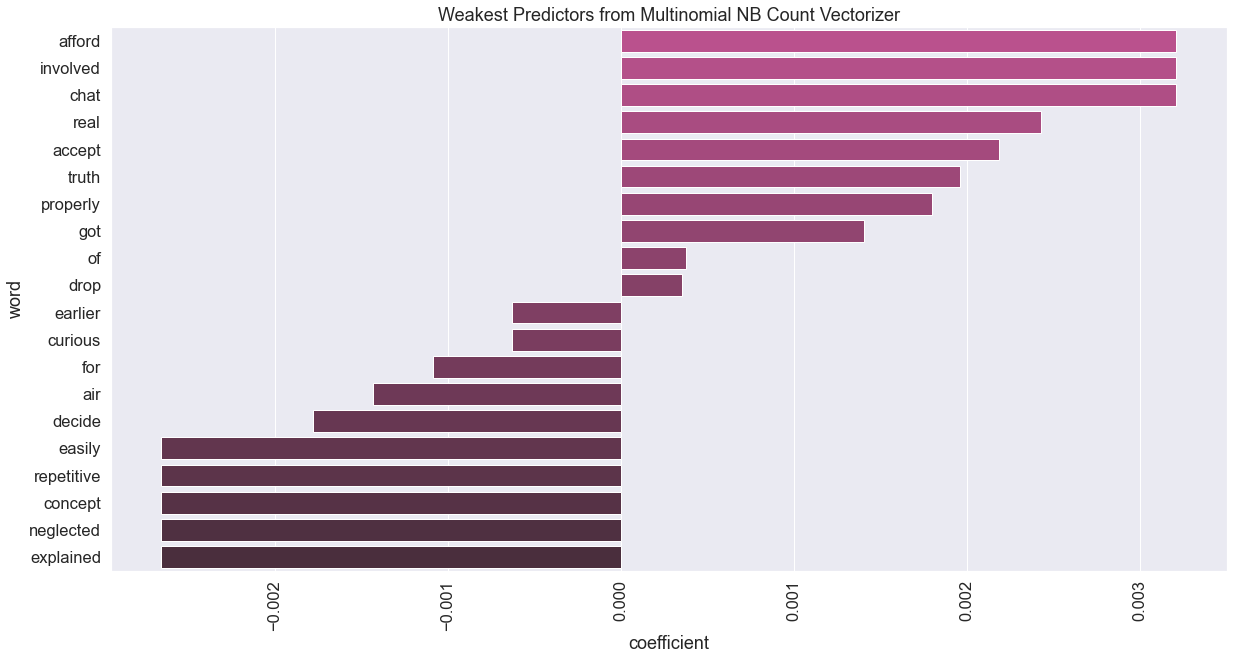

In [112]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=mid_10['word'], x=mid_10['coefficient'], palette =sns.diverging_palette(700, 300, n=50, center = "dark"))
sns.barplot(y=mid_10['word'], x=mid_10['coefficient'], palette =sns.diverging_palette(700, 300, n=50, center = "dark")).set(title="Weakest Predictors from Multinomial NB Count Vectorizer")
plt.xticks(rotation=90)
plt.show()

g.get_figure().savefig('../assets/multinb_cvec_weakest_words.jpg', dpi=160)

- As one may expect, the words with least predictive power are the ones that one would most commonly see or use with no special meaning to either subreddit, among which the weakest can actually be found in `stopwords.words('english')`.

In [113]:
%%time
preds = nb.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds, labels=nb.classes_)

CPU times: total: 15.6 ms
Wall time: 4.03 ms


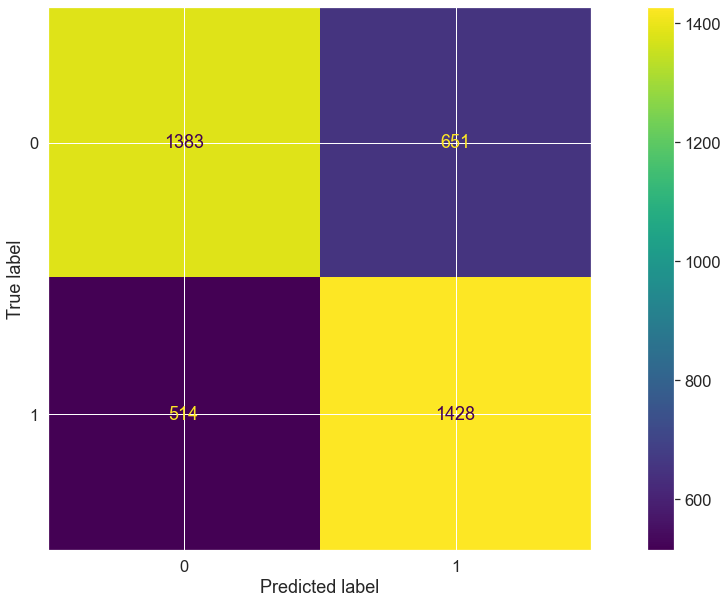

In [114]:
# View confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=nb.classes_,
                       ).plot()

plt.savefig('../assets/confusion_matrix_multinb_cvec_baseline.jpg')

While accuracy is always the most important metric, we also want to be trying to reduce the miss rate as we want to minimise the possibility of our chatbot misclassifying at-risk clients as low-risk clients.

In [115]:
# Focus on false omission rate
accuracy = (tp + tn) / (tp + tn + fp + fn )
false_omission_rate  = fn / (fn + tn)

print(f"Our baseline Mulitnomial NB model has an accuracy of {round(accuracy * 100, 1)}% on the testing data.")
print("")
print(f"Our baseline Mulitnomial NB model has a false omission rate of {round(false_omission_rate * 100, 1)}% on the testing data.")

Our baseline Mulitnomial NB model has an accuracy of 70.7% on the testing data.

Our baseline Mulitnomial NB model has a false omission rate of 27.1% on the testing data.


What this means is that if we were to use this baseline model, more than 1 in 4 of our clients that would have been predicted to be depressed would have actually been suicidal. 
</p>
</p>
This is an extremely important metric to keep in mind as de-prioritising at-risk clients could potentially be incredible harmful to their mental health and future willingness to seek treatment.

#### Analysis

- Our baseline Multinomial Naive Bayes classifier model (with subreddit stopwords) using a count vectorizer transformer has cross-validated accuracy scores of 71.2% on the training set and 70.3% on the testing set

### Multinomial NB (Baseline Score) with TF-IDF Vectorizer<a name=multinbtvecbaseline></a>


Now we will be taking a look at using a TF-IDF vectorizer as our transformer instead. A TF-IDF vectorizer should give us better results as it adjusts the predictive power of each word inversely to how prevalent that word is among all posts.

For our baseline score, we will once again just be using our subreddit stopwords of `stopwords_subr`.

In [116]:
stopwords_subr

['depression', 'suicidewatch', 'suicide', 'watch']

In [117]:
# Split the data into the training and testing sets.
X = df['alltext']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [118]:
# Instantiate a CountVectorizer for baseline model/accuracy
tvec = TfidfVectorizer(stop_words=stopwords_subr)


In [119]:
# Fit and transform the vectorizer on our corpus.
tvec.fit(X_train, y_train)

TfidfVectorizer(stop_words=['depression', 'suicidewatch', 'suicide', 'watch'])

In [120]:
X_train = tvec.transform(X_train)

In [121]:
nb = MultinomialNB()

In [122]:
nb.fit(X_train, y_train)

MultinomialNB()

In [123]:
nb.score(X_train, y_train)

0.8066909822663816

In [124]:
X_test = tvec.transform(X_test)

In [125]:
nb.score(X_test, y_test)

0.7127766599597586

In [126]:
%%time
nb_train_cv = cross_val_score(
                nb,
                X_train,
                y_train,
                cv=200
            ).mean()

CPU times: total: 3.02 s
Wall time: 3.04 s


In [127]:
%%time
nb_test_cv = cross_val_score(
                nb,
                X_test,
                y_test,
                cv=200
            ).mean()

CPU times: total: 1.17 s
Wall time: 1.16 s


In [128]:
print(f"Our baseline Multinomial NB model using a TF-IDF vectorizer has a cross-validated accuracy score of {round(nb_train_cv * 100, 1)}% on the training data.")
print("")
print(f"Our baseline Multinomial NB model using a TF-IDF vectorizer has a cross-validated accuracy score of {round(nb_test_cv * 100, 1)}% on the testing data.")

Our baseline Multinomial NB model using a TF-IDF vectorizer has a cross-validated accuracy score of 70.9% on the training data.

Our baseline Multinomial NB model using a TF-IDF vectorizer has a cross-validated accuracy score of 67.6% on the testing data.


The scores we received from using a TF-IDF vectorizer are much worse than we what received when using a count vectorizer, using the same stopwords `stopwords_subr`
</p>
With the count vectorizer, our cross-validated scores on the training data and testing set were 71.2% and 70.3% whereas with the TF-IDF vectorizer, our cross-validated scores were 70.9% and 67.6%
</p>
This suggests that there may be some words that count-vectorizer is placing importance on (that the TF-IDF vectorizer is not) that help it to predict better.

In [129]:
# creating a dataframe words_coefs that displays the predictive strength of each word for our multinomial NB model
words_coefs = pd.DataFrame(zip(tvec.get_feature_names_out(),
                (nb.feature_log_prob_[1] - nb.feature_log_prob_[0]).tolist()), columns=['word', 'coefficient'])

# ordering words_coefs by predictive strength with words that are strong predictors for r/SuicideWatch at the top 
# and words that are strong predictors for r/Depression at the bottom
words_coefs.sort_values(by='coefficient', ascending=False, inplace=True)

In [130]:
# creating a dataframe top_bot_10 of the 10 strongest predictors for both classes
top_bot_10 = pd.concat([words_coefs.head(10), words_coefs.tail(10)], axis=0)

In [131]:
# creating a columnn for absolute predictive strength
top_bot_10['coefficient_mod'] = abs(top_bot_10['coefficient'])

In [132]:
# ordering top_bot_10 by absolute predictive strength, regardless of which class they predict for
top_bot_10.sort_values(by='coefficient_mod', ascending=False, inplace=True)

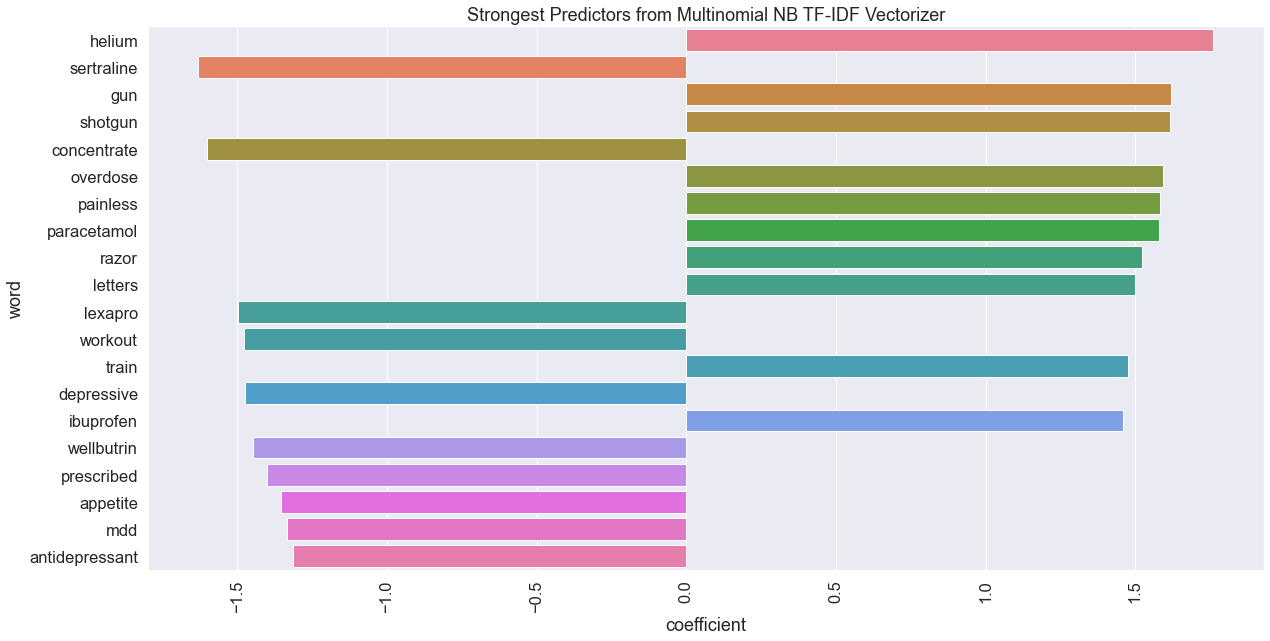

In [133]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=top_bot_10['word'], x=top_bot_10['coefficient'], palette ='husl')
sns.barplot(y=top_bot_10['word'], x=top_bot_10['coefficient'], palette ='husl').set(title="Strongest Predictors from Multinomial NB TF-IDF Vectorizer")
plt.xticks(rotation=90)
plt.show()

g.get_figure().savefig('../assets/multinb_tvec_strongest_words.jpg', dpi=160)

#### Analysis

| word | context                                                                             | count | subreddit | 
|:-----|:------------------------------------------------------------------------------------|-------|------|
|helium|Suicide attempts  | 8 |SuicideWatch|
|sertraline|Antidepressant| 33 (4) |Depression|
|gun| Largely Suicide Attempts |200 (31) | SuicideWatch |
|shotgun|Suicide attempts| 24 (1) | SuicideWatch |
|concentrate|Appears in rant about poster's feelings | 51 (12) | Depression | 
|overdose| Suicide attempts| 142 (23) | SuicideWatch | 
|painless| Suicide attempts                                             | 82 (11) | SuicideWatch | 
|paracetamol| Suicide attempts                                                      | 30 (2) |SuicideWatch| 
|razor| Suicide attempts                               | 31 (5) |SuicideWatch| 
|letters| Largely Suicide letters                                                      | 64 (12) |SuicideWatch | 
|lexapro| Antidepressant        | 37 (2) | Depression | 
|workout| Strategy to deal with depression                               | 41 (7) | Depression | 
|train| Suicide attempts                                       | 100 (24) | SuicideWatch | 
|depressive| Generally used to describe depression   | 314 (59) | Depression | 
|ibuprofen| Suicide attempts                                           | 15 (14) | SuicideWatch | 
|wellbutrin| Antidepressant|32 (6)|Depression | 
|prescribed| Prescribed medication        | 95 (18) | Depression | 
|appetite| Appetite loss linked to depression and medication                         | 34 (4) | Depression |
|mdd| Short for Major Depressive Disorder           | 28 (2)| Depression | 
|antidepressant| Antidepressant         | 55 (8) | Depression | 

- Brackets in 'count' column indicate number of posts that were found in the alternate subreddit

- Compared to the count vectorizer's list of strongest predictors, these predictors are a lot more accurate as all of the words are strong indicators of posters having active suicidal ideation (thoughts of detailed, planned suicide)  as opposed to irrelevant words or words in different languages (e.g. 'ich', 'pero')
- So while our Multinomial NB model using TF-IDF vectorizing has a lower accuracy score than our Multinomial NB model using count vectorizing, we will be using this model as our new baseline as it is seems to be modelling better on the data as it gives more importance to the correct words
- This also means we will be using TF-IDF vectorizer going forward for more realistic modelling

In [134]:
# creating a dataframe mid_10 of the 10 weakest predictors for both classes
mid_10 = pd.concat([words_coefs.loc[words_coefs['coefficient'] > 0].tail(10), 
                    words_coefs.loc[words_coefs['coefficient'] < 0].head(10)], axis=0)

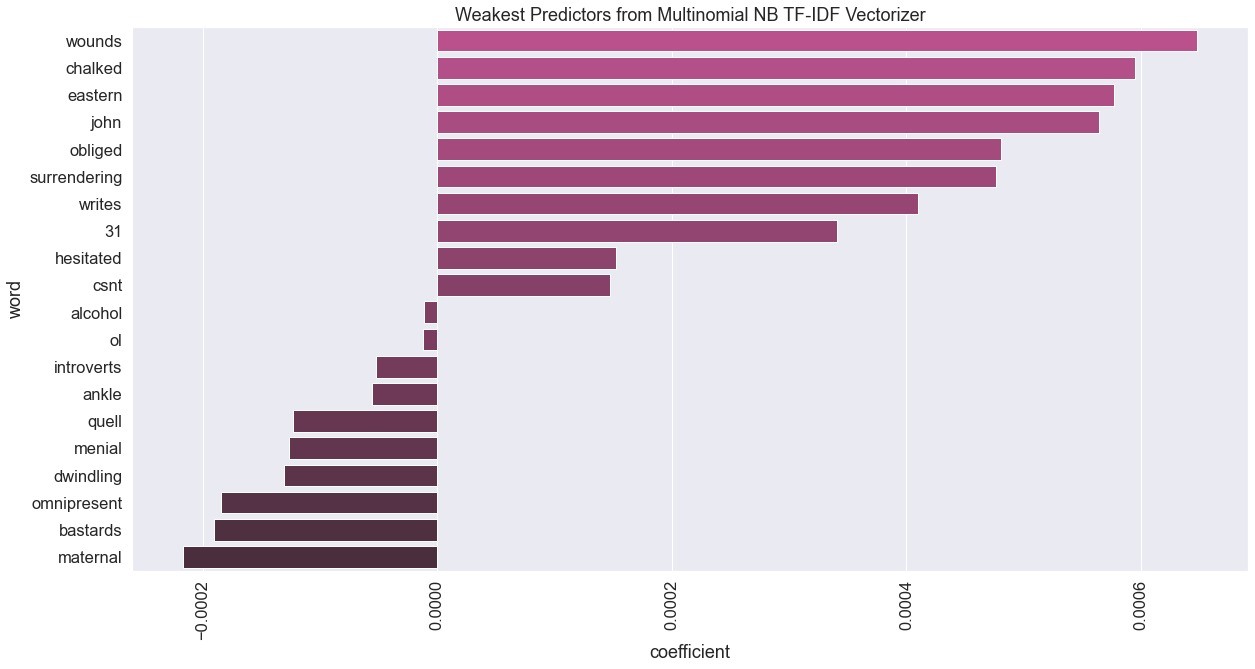

In [135]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=mid_10['word'], x=mid_10['coefficient'], palette =sns.diverging_palette(700, 300, n=50, center = "dark"))
sns.barplot(y=mid_10['word'], x=mid_10['coefficient'], palette =sns.diverging_palette(700, 300, n=50, center = "dark")).set(title="Weakest Predictors from Multinomial NB TF-IDF Vectorizer")
plt.xticks(rotation=90)
plt.show()

g.get_figure().savefig('../assets/multinb_tvec_weakest_words.jpg', dpi=160)

We can also use the results from this Multinomial NB TFIDF model to identify the weakest word predictors

In [136]:
# creating a column for words_coefs for the modulus of the coefficient
words_coefs['coefficient_mod'] = abs(words_coefs['coefficient'])

In [137]:
# sorting the words_coefs dataframe by strength of predictor, regardless of which subreddit they predict for
words_coefs.sort_values(by='coefficient_mod', ascending=False, inplace=True)

In [138]:
# assigned this new list of lowest predictive power stopwords to stopwords_tfidf. This list was found 
# by running the stopword list repeatedly through the Multinomial NB TFIDF model. The accuracy of model increased
# as we increased the modulus coefficient threshold, and we found that words with a modulus coefficient 
# less than 0.19 produced the most accurate model. Including any stronger predicting words in the stopword list 
# would then reduce the model's accuracy
stopwords_tfidf = list(words_coefs[words_coefs['coefficient_mod'] < 0.19]['word'])

In [139]:
# Get predictions
preds = nb.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds, labels=nb.classes_)

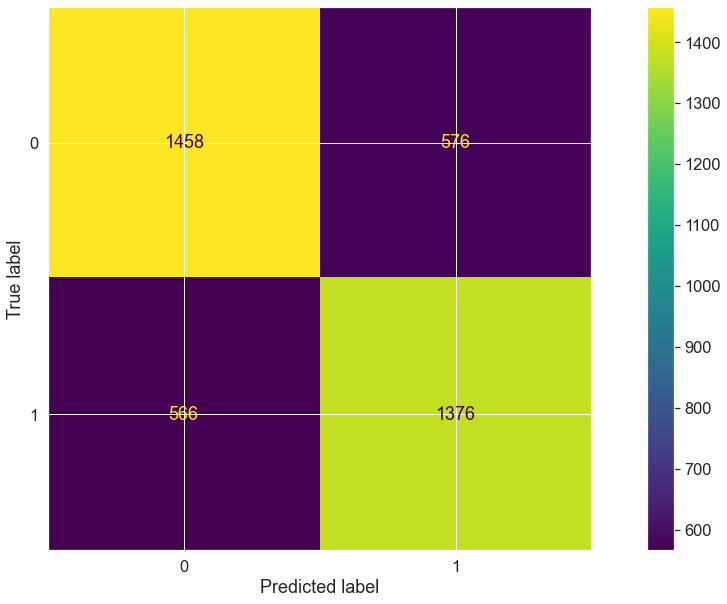

In [140]:
# View confusion matrix

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=nb.classes_,
                       ).plot()

plt.savefig('../assets/confusion_matrix_multinb_tvec_baseline.jpg')

In [141]:
# Focus on false omission rate
accuracy = (tp + tn) / (tp + tn + fp + fn )
false_omission_rate  = fn / (fn + tn)

print(f"Our baseline Multinomial NB TF-IDF model has an accuracy of {round(accuracy * 100, 1)}% on the testing data.")
print("")
print(f"Our baseline Multinomial NB TF-IDF model has a false omission rate of {round(false_omission_rate * 100, 1)}% on the testing data.")

Our baseline Multinomial NB TF-IDF model has an accuracy of 71.3% on the testing data.

Our baseline Multinomial NB TF-IDF model has a false omission rate of 28.0% on the testing data.


As expected from the cross validated score, Our baseline Multinomial NB TF-IDF model performs worse than our Multinomial NB count vectorizer model with an accuracy and false omission rate of 71.3% and 28% compared to 70.7% and 27.1% respectively.
</p>
</p>
But as mentioned above, this is more likely a truer depiction of our model's real-world performance and hence we will be using it as our baseline model.

### Random Forests (Baseline Score) with TF-IDF Vectorizer<a name=rftvecbaseline></a>

In [142]:
# Split the data into the training and testing sets.
X = df['alltext']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [143]:
# Instantiate a CountVectorizer for baseline model/accuracy
tvec = TfidfVectorizer(stop_words=stopwords_subr)


In [144]:
# Fit and transform the vectorizer on our corpus.
tvec.fit(X_train, y_train)

TfidfVectorizer(stop_words=['depression', 'suicidewatch', 'suicide', 'watch'])

In [145]:
X_train = tvec.transform(X_train)

In [146]:
rf = RandomForestClassifier()

In [147]:
%%time
rf.fit(X_train, y_train)

CPU times: total: 30.7 s
Wall time: 31 s


RandomForestClassifier()

In [148]:
rf.score(X_train, y_train)

0.9970443969312036

In [149]:
X_test = tvec.transform(X_test)

In [150]:
rf.score(X_test, y_test)

0.6800804828973843

In [151]:
%%time
rf_train_cv = cross_val_score(
                rf,
                X_train,
                y_train,
                cv=10
            ).mean()

CPU times: total: 5min 26s
Wall time: 5min 29s


In [152]:
%%time
rf_test_cv = cross_val_score(
                rf,
                X_test,
                y_test,
                cv=10
            ).mean()

CPU times: total: 43.9 s
Wall time: 44 s


In [153]:
print(f"Our baseline Random Forest model using a TF-IDF vectorizer has a cross-validated accuracy score of {round(rf_train_cv * 100, 1)}% on the training data.")
print("")
print(f"Our baseline Random Forest model using a TF-IDF vectorizer has a cross-validated accuracy score of {round(rf_test_cv * 100, 1)}% on the testing data.")

Our baseline Random Forest model using a TF-IDF vectorizer has a cross-validated accuracy score of 68.4% on the training data.

Our baseline Random Forest model using a TF-IDF vectorizer has a cross-validated accuracy score of 67.3% on the testing data.


Our baseline Random Forest TFIDF model performed worse than our baseline Multinomial NB TFIDF model with an acciuracy score of 68.5% on the training data and 67.1% on the testing data compared to the 70.9% and 67.6% of the Multinomial NB TFIDF model.
</p>
One reason for this could be that due to the number of folds in the cross-validation process. We used 200 folds for the cross-validation for our baseline Multinomial NB TFIDF model but only 10 folds for the cross-validation for our baseline Random Forest TFIDF model due to how computationally taxing the process is for Random Forest models.

In [154]:
# creating a dataframe words_coefs that displays the predictive strength of each word for our multinomial NB model
words_coefs = pd.DataFrame(zip(tvec.get_feature_names_out(),
                (rf.feature_importances_)), columns=['word', 'coefficient'])

# ordering words_coefs by predictive strength with words that are strong predictors for r/SuicideWatch at the top 
# and words that are strong predictors for r/Depression at the bottom
words_coefs.sort_values(by='coefficient', ascending=False, inplace=True)

In [155]:
# creating a dataframe top_20 of the 20 strongest predictors
top_20 = words_coefs.head(20)

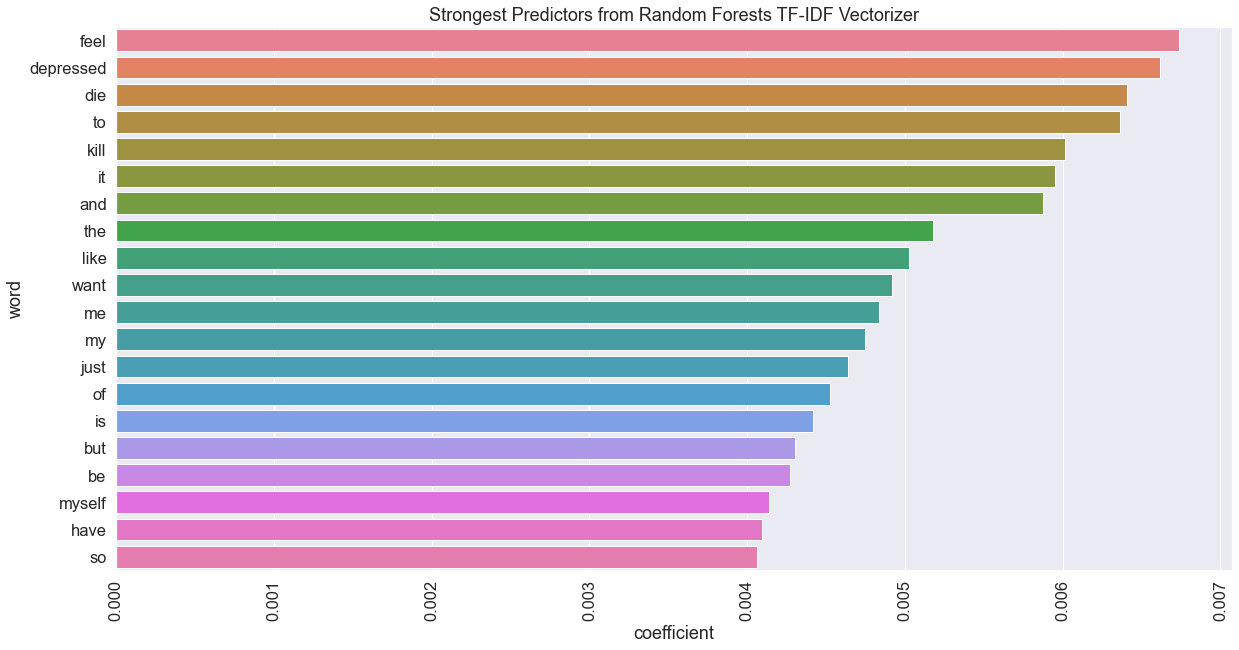

In [156]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=top_20['word'], x=top_20['coefficient'], palette ="husl")
sns.barplot(y=top_20['word'], x=top_20['coefficient'], palette ="husl").set(title="Strongest Predictors from Random Forests TF-IDF Vectorizer")
plt.xticks(rotation=90)
plt.show()



g.get_figure().savefig('../assets/rf_tvec_strongest_words.jpg', dpi=160)

Perhaps a less useful chart not only does it not advise us as to to which class these words predict to, but there also seems to be a lot of words found in `stopwords.words('english')`

In [157]:
# Get predictions
preds = rf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds, labels=rf.classes_)

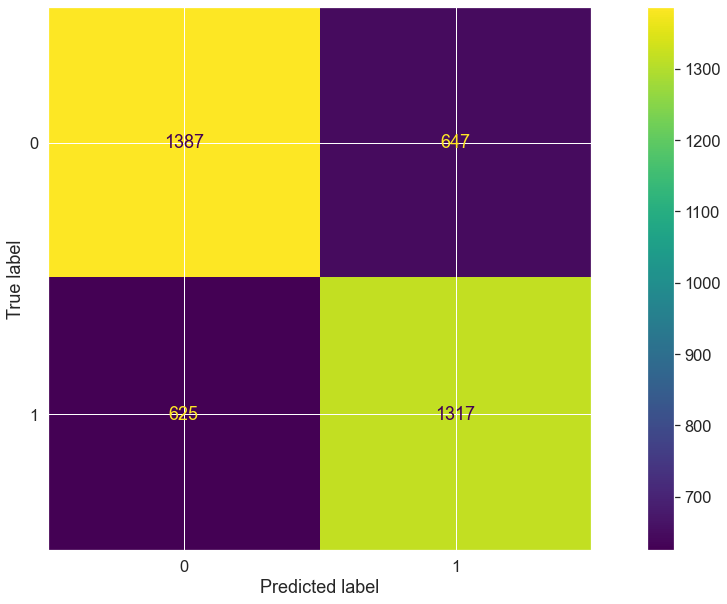

In [158]:
# View confusion matrix

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=rf.classes_,
                       ).plot()

plt.savefig('../assets/confusion_matrix_rf_tvec_baseline.jpg')

In [159]:
# Focus on false omission rate
accuracy = (tp + tn) / (tp + tn + fp + fn )
false_ommission_rate  = fn / (fn + tn)

print(f"Our baseline Random Forests model has an accuracy of {round(accuracy * 100, 1)}% on the testing data.")
print("")
print(f"Our baseline Random Forests model has a false omission rate of {round(false_omission_rate * 100, 1)}% on the testing data.")

Our baseline Random Forests model has an accuracy of 68.0% on the testing data.

Our baseline Random Forests model has a false omission rate of 28.0% on the testing data.


Our baseline Multinomial NB TFIDF model has an accuracy of 71.3% and a false omission rate of 28% on the testing data. This baseline Random Forests model has a much worse accuracy of 68.4% but an equal false omission rate of 28% on the testing data. 
</p>
</p>
Random Forests models tend to overfit on the training data, so for a completely untuned model this baseline did not perform terribly.

## Modelling<a name=modelling></a>

In order to attempt to improve our models, we will:
- Add additional stopwords, including basic english stopwords `stopwords.words('english')` and low-predicting stopwords `stopwords_tfidf`
- Use TF-IDF vectorizer since it gives a more realistic model by choosing better predictors due to weighting them against their frequency
- tokenize
- stem/lemmatize words
- gridsearch for optimal hyperparameters

### Stopwords

For our stopwords, we will combine our subreddit stopwords `stopwords_subr` with the basic English stopwords `stopwords.words('english')`, and our low-predictive value stopwords `stopwords_tfidf`.

In [160]:
stopwords_tfidf

['6yo',
 'unfriend',
 'column',
 'weekly',
 'ilines',
 'rarelly',
 'scanned',
 'stupif',
 'tresure',
 '4ch',
 'unprescribed',
 'inflexibility',
 'gotchu',
 'su1cide',
 'restriction',
 'december',
 'stabiliser',
 'ideology',
 'b6',
 'violation',
 'finite',
 'merch',
 'weenie',
 'criminology',
 'korea',
 'situationships',
 'announcing',
 'steve',
 'actualisation',
 'orthodox',
 'converting',
 'ingrained',
 'sham',
 'motherly',
 'stormtrooper',
 'pusbing',
 'sweden',
 'brim',
 'hourly',
 'goose',
 'nanny',
 'checks',
 'ramifications',
 'erupted',
 'refresh',
 'eludes',
 '1000x',
 'birthdays',
 'tesla',
 'descriptions',
 'stonewalled',
 'descendants',
 'endowed',
 'mans',
 'untreatable',
 '175mg',
 'logically',
 'childline',
 'persuade',
 'nspcc',
 'sinned',
 'worksheet',
 'pertinent',
 'plaguing',
 'leveled',
 'su1c1de',
 'folders',
 'clerical',
 'microsoft',
 'bette',
 'intelligence',
 'bunch',
 'spore',
 'slcoholics',
 'amhere',
 'muself',
 'dissolved',
 'linda',
 'signs',
 'ref',
 'che

In [161]:
stopwords_add = stopwords_subr + stopwords.words('english') + stopwords_tfidf

### Tokenizing, Lemmatizing, and Stemming

We will need to tokenize and lemmatize both our corpus and our stopwords

We are using a new tokenizer that only captures words of at least two letters that do not have non-alphabetical characters in their first two words.

In [162]:
tokenizer = RegexpTokenizer(r"(?u)\b[a-z][a-z]+\b")

In [163]:
# corpus tokenizer function
def post_tokenizer(row):
    post_tokens = tokenizer.tokenize(row)
    return post_tokens

In [164]:
# tokenizing the corpus
alltext_tokenized = df['alltext'].map(post_tokenizer)

In [165]:
# making tokenized corpus feedable 
def feedable_tokenizer(row):
    post_tokens = tokenizer.tokenize(row)
    return " ".join(post_tokens)

In [166]:
alltext_tokenized_feedable = df['alltext'].map(feedable_tokenizer)

In [167]:
# instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [168]:
# corpus lemmatizer function
def post_token_lemmatizer(row):
    post_tokens_lemmatized = [lemmatizer.lemmatize(token) for token in row]
    return " ".join(post_tokens_lemmatized)

In [169]:
# lemmatizing the corpus
alltext_lemmatized = alltext_tokenized.map(post_token_lemmatizer)

In [170]:
# instantiate PorterStemmer.
p_stemmer = PorterStemmer()

In [171]:
# corpus stemming function
def post_token_stemmer(row):
    post_tokens_stemmed = [p_stemmer.stem(token) for token in row]
    return " ".join(post_tokens_stemmed)

In [172]:
# stemming the corpus
alltext_stemmed = alltext_tokenized.map(post_token_stemmer)

If we are to lemmatize our corpus, we would also need to lemmatize our stopwords:

In [173]:
stopwords_add_lem = [lemmatizer.lemmatize(word) for word in stopwords_add]

Same goes for stemming:

In [174]:
stopwords_add_stem = [p_stemmer.stem(word) for word in stopwords_add]

And tokenizing:

In [175]:
stopwords_add_tok = [tokenizer.tokenize for word in stopwords_add]

### Multinomial NB

In [176]:
# Split the data into the training and testing sets.
X = alltext_tokenized_feedable
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [177]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords_add_tok)),
    ('nb', MultinomialNB())
])

In [178]:
pipe_params = {
    'tvec__min_df': [0],
    'tvec__max_df':[1, 0.99, 0.98, ],
    'tvec__ngram_range': [(1, 1), (1, 2),(1, 3)]
}

In [179]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv=10,
                  n_jobs=-1) 

In [180]:
%%time
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

CPU times: total: 1min 3s
Wall time: 2min 50s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=[<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='(?u)\\b[a-z][a-z]+\\b', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>,
                                                                    <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='(?u)\\b[a-z][a-z]+\\b', gaps=False, discard_empty=...
                                                                    <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='(?u)\\b[a-z][a-z]+\\b', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>,
                                                                    <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='(?u)\\b[a-z][a-z]+\\b', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>, ...])),
                                 

In [181]:
gs.score(X_train, y_train)

0.9220223871211168

In [182]:
gs.score(X_test, y_test)

0.7208249496981891

In [183]:
gs.best_params_

{'tvec__max_df': 0.99, 'tvec__min_df': 0, 'tvec__ngram_range': (1, 2)}

In [184]:
gs.best_score_

0.7205381687084188

In [185]:
print(f"Our refined Multinomial NB model with TF-IFD vectorizing has a 200 fold cross-validated accuracy score of {round(gs.score(X_train, y_train) * 100, 1)}% on the training data.")
print("")
print(f"Our refined Multinomial NB model with TF-IFD vectorizing has a 200 fold cross-validated accuracy score of {round(gs.score(X_test, y_test) * 100, 1)}% on the testing data.")

Our refined Multinomial NB model with TF-IFD vectorizing has a 200 fold cross-validated accuracy score of 92.2% on the training data.

Our refined Multinomial NB model with TF-IFD vectorizing has a 200 fold cross-validated accuracy score of 72.1% on the testing data.


In [186]:
# creating a dataframe words_coefs that displays the predictive strength of each word for our multinomial NB model
words_coefs = pd.DataFrame(zip(gs.best_estimator_[0].get_feature_names_out(),
                (gs.best_estimator_[1].feature_log_prob_[1] - gs.best_estimator_[1].feature_log_prob_[0]).tolist()), columns=['word', 'coefficient'])

# ordering words_coefs by predictive strength with words that are strong predictors for r/SuicideWatch at the top 
# and words that are strong predictors for r/Depression at the bottom
words_coefs.sort_values(by='coefficient', ascending=False, inplace=True)

In [187]:
# creating a dataframe top_bot_10 of the 10 strongest predictors for both classes
top_bot_10 = pd.concat([words_coefs.head(10), words_coefs.tail(10)], axis=0)

In [188]:
# creating a columnn for absolute predictive strength
top_bot_10['coefficient_mod'] = abs(top_bot_10['coefficient'])

In [189]:
# ordering top_bot_10 by absolute predictive strength, regardless of which class they predict for
top_bot_10.sort_values(by='coefficient_mod', ascending=False, inplace=True)

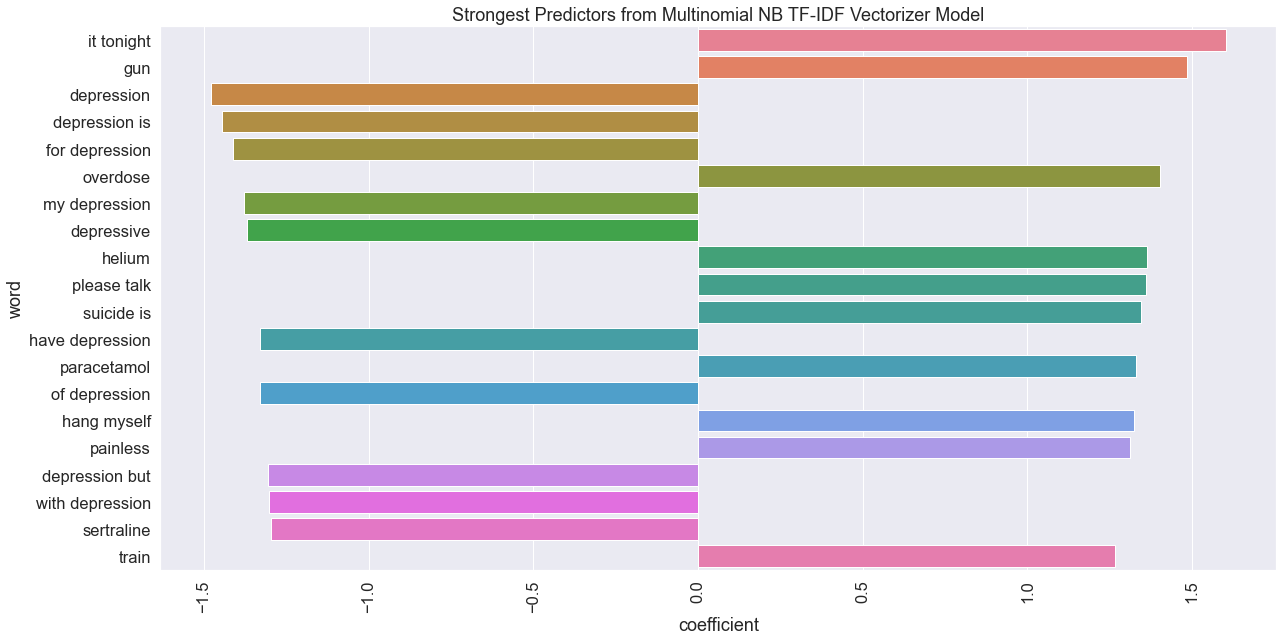

In [190]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=top_bot_10['word'], x=top_bot_10['coefficient'], palette ="husl")
sns.barplot(y=top_bot_10['word'], x=top_bot_10['coefficient'], palette ="husl").set(title="Strongest Predictors from Multinomial NB TF-IDF Vectorizer Model")
plt.xticks(rotation=90)
plt.show()

g.get_figure().savefig('../assets/best_multinb_tvec_model_strongest_words', dpi=160)

In [191]:
# creating a dataframe mid_10 of the 10 weakest predictors for both classes
mid_10 = pd.concat([words_coefs.loc[words_coefs['coefficient'] > 0].tail(10), 
                    words_coefs.loc[words_coefs['coefficient'] < 0].head(10)], axis=0)

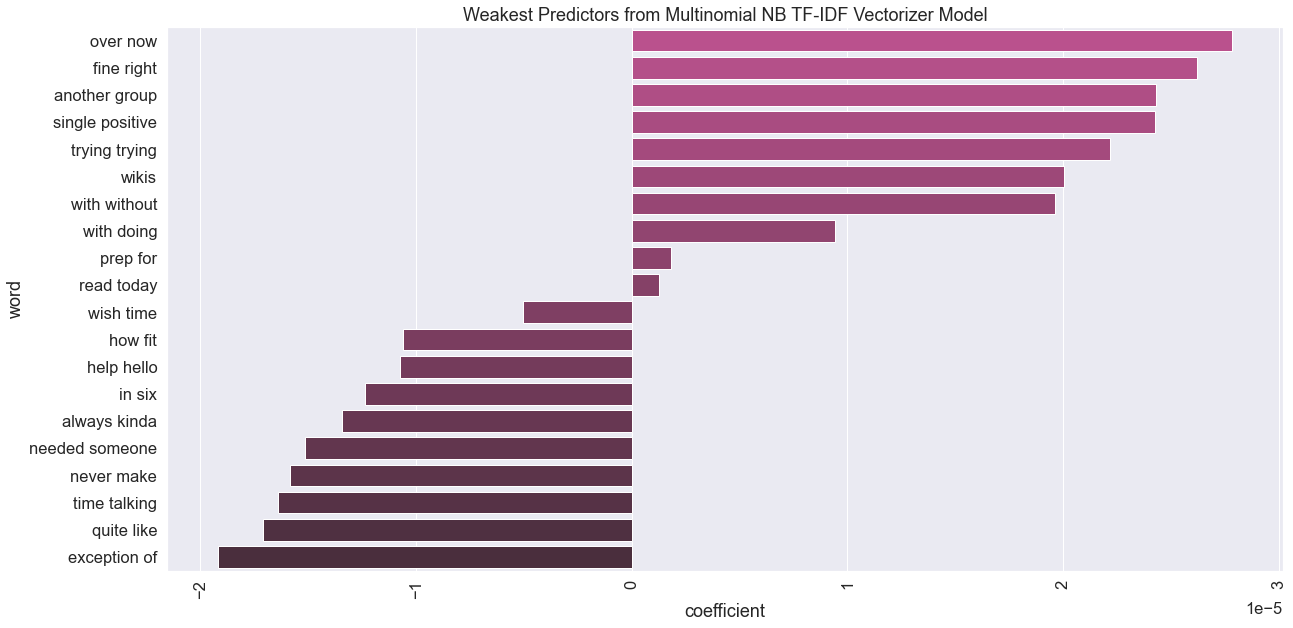

In [192]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=mid_10['word'], x=mid_10['coefficient'], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
sns.barplot(y=mid_10['word'], x=mid_10['coefficient'], palette =sns.diverging_palette(700, 300, n=50, center = "dark")).set(title="Weakest Predictors from Multinomial NB TF-IDF Vectorizer Model")
plt.xticks(rotation=90)
plt.show()

g.get_figure().savefig('../assets/best_multinb_tvec_model_weakest_words', dpi=160)

In [193]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds, labels=gs.best_estimator_[1].classes_)

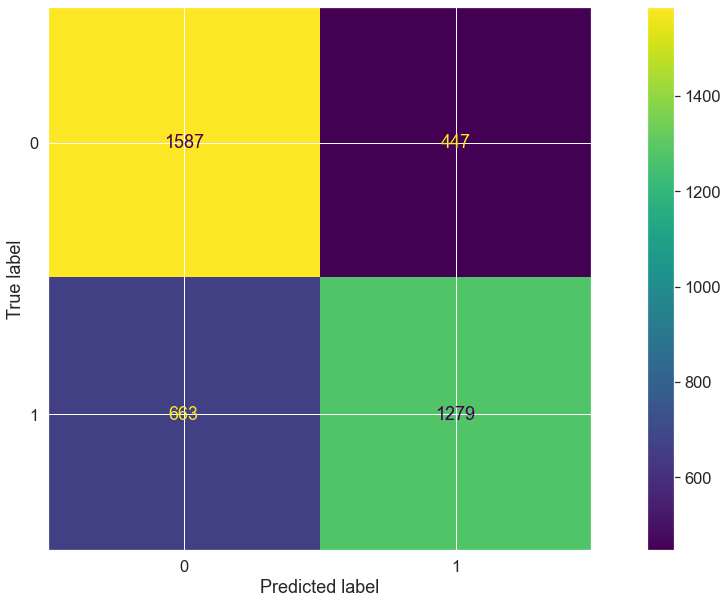

In [194]:
# View confusion matrix

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=gs.best_estimator_[1].classes_,
                       ).plot()

plt.savefig('../assets/confusion_matrix_multinb_tvec_best.jpg', dpi=160)

In [195]:
# Focus on false omission rate
accuracy = (tp + tn) / (tp + tn + fp + fn )
false_omission_rate  = fn / (fn + tn)

print(f"Our baseline Multinomial NB model has an accuracy of {round(accuracy * 100, 1)}% on the testing data.")
print("")
print(f"Our baseline Multinomial NB model has a false omission rate of {round(false_omission_rate * 100, 1)}% on the testing data.")

Our baseline Multinomial NB model has an accuracy of 72.1% on the testing data.

Our baseline Multinomial NB model has a false omission rate of 29.5% on the testing data.


#### Analysis

- Our baseline model had an accuracy of 71.3% on the testing set and a false omission rate of 28.0% on the testing set
- Increased accuracy by 0.8%, but also increased the false omission rate by 1.5%
- Tuning made model more aggressive in classifying:
    - True Negatives increased from 1458 to 1587
    - False Positives decreased from 576 to 447
    - False Negatives increased from 566 to 663
    - True Positives decreased from 1376 to 1279
- Our baseline model's accuracy and hence false omission rate were not cross-validated, therefore they may be inaccurate
- Even though accuracy increased, the model increased it by being more aggressive in predicting for the 0 class-the r/Depression class, compromising on the predictions for the 1 class-the r/SuicideWatch class.

### Tokenizing, Lemmatizing, and Stemming

We will need to tokenize and lemmatize both our corpus and our stopwords

We are using a new tokenizer that only captures words of at least two letters that do not have non-alphabetical characters in their first two words.

In [196]:
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")

In [197]:
# corpus tokenizer function
def post_tokenizer(row):
    post_tokens = tokenizer.tokenize(row)
    return post_tokens

In [198]:
# tokenizing the corpus
alltext_tokenized = df['alltext'].map(post_tokenizer)

In [199]:
# making tokenized corpus feedable 
def feedable_tokenizer(row):
    post_tokens = tokenizer.tokenize(row)
    return " ".join(post_tokens)

In [200]:
# feedable tokenized corpus
alltext_tokenized_feedable = df['alltext'].map(feedable_tokenizer)

In [201]:
# instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [202]:
# corpus lemmatizer function
def post_token_lemmatizer(row):
    post_tokens_lemmatized = [lemmatizer.lemmatize(token) for token in row]
    return " ".join(post_tokens_lemmatized)

In [203]:
# lemmatizing the corpus
alltext_lemmatized = alltext_tokenized.map(post_token_lemmatizer)

In [204]:
# instantiate PorterStemmer.
p_stemmer = PorterStemmer()

In [205]:
# corpus stemming function
def post_token_stemmer(row):
    post_tokens_stemmed = [p_stemmer.stem(token) for token in row]
    return " ".join(post_tokens_stemmed)

In [206]:
# stemming the corpus
alltext_stemmed = alltext_tokenized.map(post_token_stemmer)

If we are to lemmatize our corpus, we would also need to lemmatize our stopwords:

In [207]:
stopwords_add_lem = [lemmatizer.lemmatize(word) for word in stopwords_add]

Same goes for stemming:

In [208]:
stopwords_add_stem = [p_stemmer.stem(word) for word in stopwords_add]

And tokenizing:

In [209]:
stopwords_add_tok = [tokenizer.tokenize for word in stopwords_add]

### Random Forest

In [210]:
# Split the data into the training and testing sets.
X = df['alltext']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [211]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords_add)),
    ('rf', RandomForestClassifier())
])

In [212]:
pipe_params = {
    'tvec__max_df':[0.95,0.92,.98],
    'tvec__ngram_range': [(1, 2)],
    'rf__max_depth': [88,86],
    'rf__min_samples_leaf': [ 4,5],
}

In [213]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv=10,
                  n_jobs=-1) 

In [214]:
%%time
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

CPU times: total: 16.4 s
Wall time: 3min 23s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['depression',
                                                                    'suicidewatch',
                                                                    'suicide',
                                                                    'watch',
                                                                    'i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                  

In [215]:
gs.score(X_train, y_train)

0.7881398566218086

In [216]:
gs.score(X_test, y_test)

0.7092555331991952

In [217]:
gs.best_params_

{'rf__max_depth': 88,
 'rf__min_samples_leaf': 4,
 'tvec__max_df': 0.95,
 'tvec__ngram_range': (1, 2)}

In [218]:
gs.best_score_

0.7106642711162237

In [219]:

print(f"Our refined Random Forest model with TF-IFD vectorizing has a 10 fold cross-validated accuracy score of {round(gs.score(X_train, y_train) * 100, 1)}% on the training data.")
print("")
print(f"Our refined Random Forest model with TF-IFD vectorizing has a 10 fold cross-validated accuracy score of {round(gs.score(X_test, y_test) * 100, 1)}% on the testing data.")

Our refined Random Forest model with TF-IFD vectorizing has a 10 fold cross-validated accuracy score of 78.8% on the training data.

Our refined Random Forest model with TF-IFD vectorizing has a 10 fold cross-validated accuracy score of 70.9% on the testing data.


In [220]:
# creating a dataframe words_coefs that displays the predictive strength of each word for our multinomial NB model
words_coefs = pd.DataFrame(zip(gs.best_estimator_[0].get_feature_names_out(),
                (gs.best_estimator_[1].feature_importances_).tolist()), columns=['word', 'coefficient'])

# ordering words_coefs by predictive strength with words that are strong predictors for r/SuicideWatch at the top 
# and words that are strong predictors for r/Depression at the bottom
words_coefs.sort_values(by='coefficient', ascending=False, inplace=True)

In [221]:
# creating a dataframe top_20 of the 20 strongest predictors
top_20 = words_coefs.head(20)

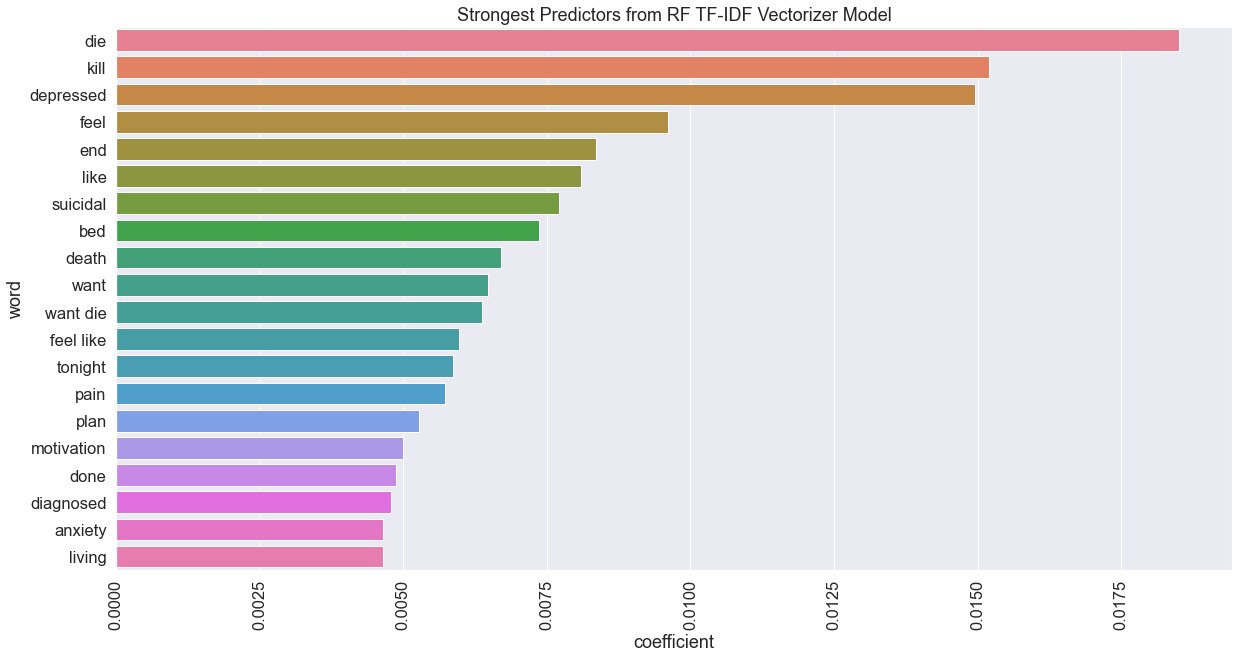

In [222]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
sns.set_color_codes("pastel")
g = sns.barplot(y=top_20['word'], x=top_20['coefficient'], palette ='husl')
sns.barplot(y=top_20['word'], x=top_20['coefficient'], palette ='husl').set(title="Strongest Predictors from RF TF-IDF Vectorizer Model")
plt.xticks(rotation=90)
plt.show()

g.get_figure().savefig('../assets/best_rf_tvec_model_strongest_words', dpi=160)

In [223]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds, labels=gs.best_estimator_[1].classes_)

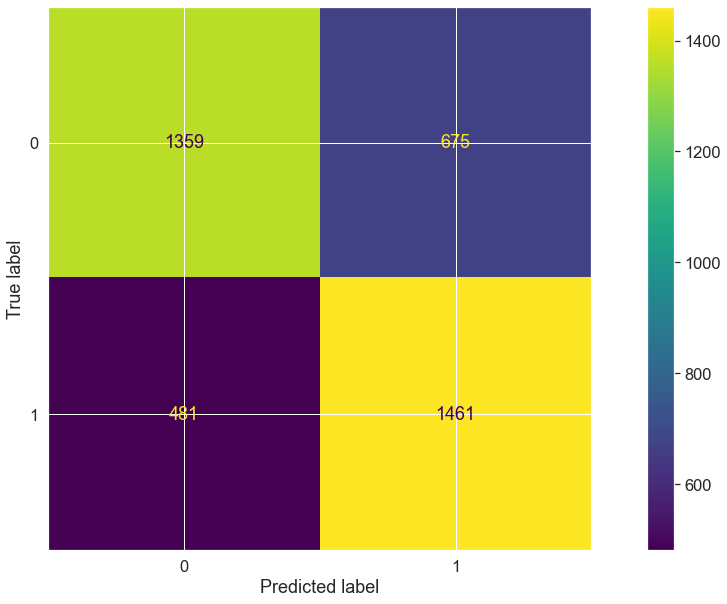

In [224]:
# View confusion matrix

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=gs.best_estimator_[1].classes_,
                       ).plot()

plt.savefig('../assets/confusion_matrix_rf_tvec_best', dpi=160)

In [225]:
# Focus on false omission rate
accuracy = (tp + tn) / (tp + tn + fp + fn )
false_omission_rate  = fn / (fn + tn)

print(f"Our Refined Random Forest model has an accuracy of {round(accuracy * 100, 1)}% on the testing data.")
print("")
print(f"Our Refined Random Forest model has a false omission rate of {round(false_omission_rate * 100, 1)}% on the testing data.")

Our Refined Random Forest model has an accuracy of 70.9% on the testing data.

Our Refined Random Forest model has a false omission rate of 26.1% on the testing data.


Our refined Random Forest model has an accuracy of 70.9%, worse than both the 72.1% of our refined Multinomial NB model and the 71.3% of our baseline model. However, it has the lowest false omission rate out of all of them at 26.1% compared to 29.5% and 28.0% respectively.
</p>
</p>
This model seems to be able to not only detect the targeted class better, but also detect the False Negatives better at the expense of being worse at identifying False Positives and True Negatives

# Insights<a name=insights></a>


- Although accuracy is the score that we were hoping to improve, there are correct ways and wrong ways to achieve this goal
- In our first model of Multinomial NB with TF-IDF vectorizer, we had an increase in accuracy of 0.8% but that was accompanied by a larger increase of false omission rate of 1.5%
    - When comparing the first model with our baseline model, we could see that our accuracy only increased due to an increase in the number of True Negatives detected, when what we are more concerned with are the number of True Positives which decreased
    - In addition to the number of True Negatives increasing, there was also an increase in the False Negatives, together increasing our false omission rate when we should be looking to decrease it
    - Therefore, while the accuracy of our model did increase as we were looking to do, it came at the expense of an increase in our false omission rate. This should be avoidable
    
- In contrast, our second model of Random Forests with TF-IDF vectorizer had a decrease in accuracy of 0.4%, but also a proportionally larger decrease in the false omission rate of 1.9%
- Comparing the confusion matrices, we noted that although the accuracy decreased, there was an increase in both the number of True Negative and False Negative predictions, which were responsible for the significant decrease in the false omission rate. This is the kind of outcome that we should be striving to achieve

# Conclusion and Recommendations<a name=conclusion></a>

- Between our Multinomial NB TF-IDF vectorizer model and our Random Forest TF-IDF model, I would recommend using the Random Forest TF-IDF model, as it has only a 0.4% lower accuracy score of 70.9% on our baseline model, but has a better false omission rate of 26.1% as opposed to the 28% on the baseline model.
- Additionally, in general, it must be said that the model is not yet ready for commercial use just yet as the accuracy 
- What would help to improve the data would be if there were more accurate data. Currently the data that we are using are from public sources which, while easily accessible, is also very unreliable. As stated at the beginning of this document, we had to make large assumptions when using this data, and based on how the classifier has turned out, those assumptions were likely too unreasonable to make

1) **The subreddits have been well-moderated to the extent that there are no spam or off-topic posts**:</p>
 - This is probably the most realistic assumption. Based on the data that we had gathered and through cursory data exploration, we found no trace of any spam or off-topic posts

2) **Posters are accurately conveying their emotions in their posts and are submitting their posts to the appropriate subreddits**
 - When even most well-adjusted people are not in tune with their emotions and are not honest with themselves, it is even more of an ask to expect those under mental duress to possess that same level of self-awareness
 - However, this is not just limited to those who are feeling depressed, but there could possibly be posters who do not genuinely feel depressed or suicidal, and so the language they use would be different and train our classifier wrongly
 - At the end of the day, all posters posting to the subreddit are self-diagnosed, so there is no way of confirming that they are actually suffering from the relevant mental health issues. As such, this assumption was almost impossible to hold true

3) **Posters are aware of the existence of both subreddits**:
 - Difficult assumption to make as a quick visit to each subreddit shows us that r/Depression is more well-known just based on number of subscribers alone (r/Depression has 850,000 subscribers while r/SuicideWatch only has 342 ,000 subscribers)
 - If posters know r/Depression but not r/SuicideWatch, they may just post anything to do with depression in r/Depression, no matter if they feel suicidal or not